In [1]:
# pip install numpy micrograd matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
class Value:
    def __init__(self, x, _children=set(), _op='', label=''):
        self.data = x
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    def __radd__(self, other): 
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = +other.data * out.grad
            other.grad = +self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        # assert isinstance(other, (int, float)),
        out = Value(self.data ** other, (self,), label=f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other-1) * out.grad)
        self._backward = _backward
        return out
    
    def __repr__(self):
        return f"Value=(data={self.data})"

    def exp(self): 
        x = self.data 
        out = Value(math.exp(x), (self, ), label='exp')
        def _backward():
            self.grad = out.data * out.grad
        self._backward = _backward

        return out

    def __truediv__(self, other):
        return self * (other ** -1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
   
        
        

In [175]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

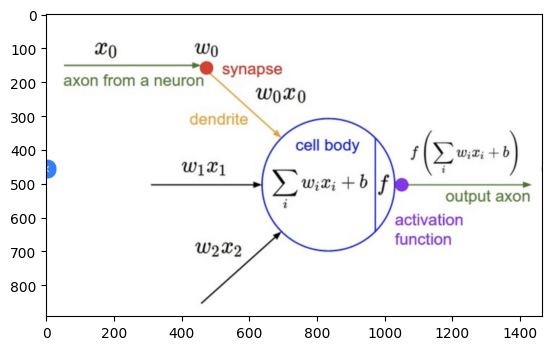

In [43]:
import matplotlib.image as mpimg
img=mpimg.imread('neuronMathModel.png')
plt.imshow(img)

In [44]:
# Inputs to a neuron are called axons and mathematically they can be x0, x1... xn. Inputs come to a neuron through synapses. 
# Each synapse has a weight associated with it. When an input x0 comes to neuron through a synapse s with weight w0, the weight of synapse w0 gets multiplied to x0. 

# If a neuron has n synapses and n inputes are sent through those n synapses, overall input to a neuron becomes:
# x0w0 + x1w1 + .... + xnwn
# Bias
# Bias of a neuron is the 'happy trigger' that is applies to the output
# So the neuron will be applying bias be to the afformentioned input. (x0w0 + x1w1 + ... + nxwn) + b
# Apply the activation function to the output of n to get the final output of the neuron




In [186]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [187]:
o.backward()

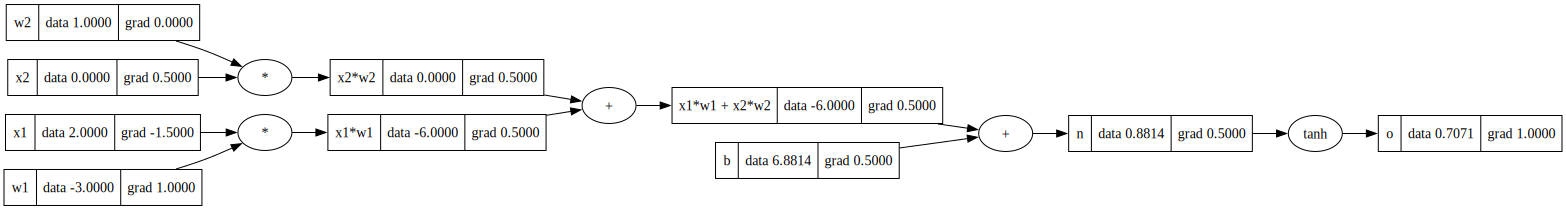

In [188]:
draw_dot(o)

In [184]:
# Check if our code handles the case where same node contributes more than once. 
# In case of multivariable chain rule, the gradients get accumulated, hence we have added gradients in _backward func of each operation
a = Value(3.0, label='a')
c = Value(2.0, label = 'c')
b = a / c

In [190]:
## Try this using pytorch


In [202]:
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()

n = x1 * w1 + x2*w2 + b
o = n.tanh()
o
o.backward()

In [208]:
print("x1 grad:", x1.grad.item())
print("x2 grad:", x2.grad.item())
print("w1 grad:", w1.grad.item())
print("w2 grad:", w2.grad.item())

x1 grad: -1.5000003851533106
x2 grad: 0.5000001283844369
w1 grad: 1.0000002567688737
w2 grad: 0.0
